### Entrainement de modéles

##### 1. Récupérer les embeddings depuis ChromaDB

In [7]:
def get_collection(client, name):
    train_collection = client.get_collection(name=f'train_collection_{name}')
    test_collection = client.get_collection(name=f'test_collection_{name}')

    print(f'Train - {name.capitalize() :15s} ->     ', train_collection.count())
    print(f'Test  - {name.capitalize() :15s} ->     ', test_collection.count())
    print('')

    return [train_collection, test_collection]


In [8]:
import chromadb

client = chromadb.PersistentClient(path='../data/chroma_db')

train_collection_clean, test_collection_clean = get_collection(client, 'clean')

train_collection_mentions, test_collection_mentions = get_collection(client, 'mentions')

train_collection_undersampling, test_collection_undersampling = get_collection(client, 'undersampling')

Train - Clean           ->      12410
Test  - Clean           ->      2191

Train - Mentions        ->      12410
Test  - Mentions        ->      2191

Train - Undersampling   ->      7254
Test  - Undersampling   ->      1281



##### 2. Extraction de labels et d'embeddings

In [9]:
import numpy as np

def extract_train_test_dataframes(train_collection, test_collection):
    train_metadatas = train_collection.get(include=["metadatas", "embeddings"])
    test_metadatas = test_collection.get(include=["metadatas", "embeddings"])

    train_labels = [metadata['label'] for metadata in train_metadatas['metadatas']]
    test_labels = [metadata['label'] for metadata in test_metadatas['metadatas']]

    train_embeddings = [emb for emb in train_metadatas['embeddings']]
    test_embeddings = [emb for emb in test_metadatas['embeddings']]

    X_train = np.array(train_embeddings)
    y_train = np.array(train_labels)
    X_test = np.array(test_embeddings)
    y_test = np.array(test_labels)

    print('X_Train ->', len(X_train))
    print('Y_Train ->', len(y_train))
    print('X_Test  ->', len(X_test))
    print('Y_Test  ->', len(y_test))

    return [X_train, y_train, X_test, y_test]

- Data 1: data_clean

In [14]:
clean_sets = \
extract_train_test_dataframes(train_collection_clean, test_collection_clean)

X_Train -> 12410
Y_Train -> 12410
X_Test  -> 2191
Y_Test  -> 2191


- Data 2: data_with_mentions

In [15]:
mentions_sets = \
extract_train_test_dataframes(train_collection_mentions, test_collection_mentions)

X_Train -> 12410
Y_Train -> 12410
X_Test  -> 2191
Y_Test  -> 2191


- Data 3: data_balanced_undersampling

In [16]:
undersampling_sets = \
extract_train_test_dataframes(train_collection_undersampling, test_collection_undersampling)

X_Train -> 7254
Y_Train -> 7254
X_Test  -> 1281
Y_Test  -> 1281


##### 3. Créer des fonctions d'entraînement de différents modèles ML sur les embeddings.

In [68]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC, SVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score


- Fonction pour entrainer un modèle

In [ ]:
def train_model(model, X_train, y_train, X_test, y_test, name, models):

    print(f"--- Entrainemnt du modèle --------> {name}", '\n')

    # Entrainer
    model.fit(X_train, y_train)

    # Prédire
    y_pred = model.predict(X_test)

    # Metrics
    acc = accuracy_score(y_test, y_pred)
    pr = precision_score(y_test, y_pred, average="micro")
    rc = recall_score(y_test, y_pred, average="micro")
    f1 = f1_score(y_test, y_pred, average="micro")

    # Gap enter train vs test
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)
    
    gap = train_acc - test_acc

    # Affichage
    print("Accuracy --> ", acc, '\n')

    print("Train accuracy:", train_acc)
    print("Test accuracy:", test_acc)
    print("Generalization gap:", gap, '\n')
    
    print("Rapport de classification:\n")
    print(classification_report(y_test, y_pred))

    print('-----------------------------------------------\n\n')

    models[name] = model

    return [name, acc, pr, rc, f1, gap]

- Fonction pour évaluer un modèle

In [ ]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

def evaluate_model(model, X_train, y_train, X_test, y_test, name):

    if (name in ['XGBoost']):
        return
        
    plt.figure(figsize=(15, 7))

    #### 1st Plot

    plt.subplot(1, 2, 1)

    train_sizes, train_scores, test_scores = learning_curve(
        model, 
        X_train, y_train, 
        cv=5,
        train_sizes=np.linspace(0.1, 1.0, 5),
        scoring='accuracy',
        n_jobs=-1
    )

    train_mean = np.mean(train_scores, axis=1)
    test_mean  = np.mean(test_scores, axis=1)

    plt.plot(train_sizes, train_mean, label='Train Accuracy')
    plt.plot(train_sizes, test_mean, label='Test Accuracy')
    plt.xlabel('Training set size')
    plt.ylabel('Accuracy')
    plt.title('Learning Curve')
    plt.legend()

    ### 2nd Plot

    if (name in ["Linear SVC"]):
        plt.show()
        return

    classes = np.unique(y_train)
    n_classes = len(classes)

    # Binarize train and test labels
    y_train_bin = label_binarize(y_train, classes=classes)
    y_test_bin  = label_binarize(y_test, classes=classes)

    # Get predicted probabilities
    y_train_scores = model.predict_proba(X_train)
    y_test_scores  = model.predict_proba(X_test)

    plt.subplot(1, 2, 2)
    
    for i in range(n_classes):
        # ROC for train
        fpr_train, tpr_train, _ = roc_curve(y_train_bin[:, i], y_train_scores[:, i])
        auc_train = auc(fpr_train, tpr_train)
        plt.plot(fpr_train, tpr_train, color='red', linestyle='-', label=f"Train Class {classes[i]} (AUC={auc_train:.2f})")
        
        # ROC for test
        fpr_test, tpr_test, _ = roc_curve(y_test_bin[:, i], y_test_scores[:, i])
        auc_test = auc(fpr_test, tpr_test)
        plt.plot(fpr_test, tpr_test, color="green", linestyle='-', label=f"Test  Class {classes[i]} (AUC={auc_test:.2f})")


    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Train vs Test ROC — Multiclass (One-vs-Rest)")
    plt.legend()
    plt.grid(True)
    plt.show()

- Fonction pour entrainer et évaluer plusieurs modéles

In [71]:
def train_evaluate_model(model, X_train, y_train, X_test, y_test, name, models):

    # Entrainer le modéle

    scores = train_model(
        model,
        X_train, y_train, X_test, y_test,
        name,
        models
    )

    # Evaluer un modéle

    evaluate_model(
        model,
        X_train, y_train, X_test, y_test,
        name
    )

    return scores

- Fonction pour entrainer plusieurs modèles

In [72]:
def train_multiple_models(X_train, y_train, X_test, y_test, balanced = None):

    models = {}
    scores = []

    # Logistic Regression

    sc1 = train_evaluate_model(
        LogisticRegression(class_weight=balanced),
        X_train, y_train, X_test, y_test,
        "Logistic Regression",
        models
    )

    # Random Forest
   
    sc2 = train_evaluate_model(
        RandomForestClassifier(class_weight=balanced),
        X_train, y_train, X_test, y_test,
        "Random Forest",
        models
    )

    # Linear SVC
   
    sc3 = train_evaluate_model(
        LinearSVC(class_weight=balanced),
        X_train, y_train, X_test, y_test,
        "Linear SVC",
        models
    )

    # XGBoost
   
    sc4 = train_evaluate_model(
        XGBClassifier(),
        X_train, y_train, X_test, y_test,
        "XGBoost",
        models
    )

    # SVC
   
    sc5 = train_evaluate_model(
        SVC(probability=True, class_weight=balanced),
        X_train, y_train, X_test, y_test,
        "SVC",
        models
    )

    for score in [sc1, sc2, sc3, sc4, sc5]:
        scores.append(score)

    scores_df = pd.DataFrame(scores, columns=["Name", "Accuracy", "Precision", "Recall", "F1", "Train_Test Gap"])
        
    return [scores_df, models]

##### 4. Entraîner et évaluer les modèles de machine learning sur des données différentes.

##### 4.1. Data 1: data_clean

--- Entrainemnt du modèle --------> Logistic Regression 

Accuracy -->  0.8512094933820173 

Train accuracy: 0.863013698630137
Test accuracy: 0.8512094933820173
Generalization gap: 0.011804205248119648
Rapport de classification:

              precision    recall  f1-score   support

           0       0.89      0.94      0.91      1374
           1       0.73      0.70      0.71       464
           2       0.84      0.72      0.78       353

    accuracy                           0.85      2191
   macro avg       0.82      0.79      0.80      2191
weighted avg       0.85      0.85      0.85      2191

-----------------------------------------------




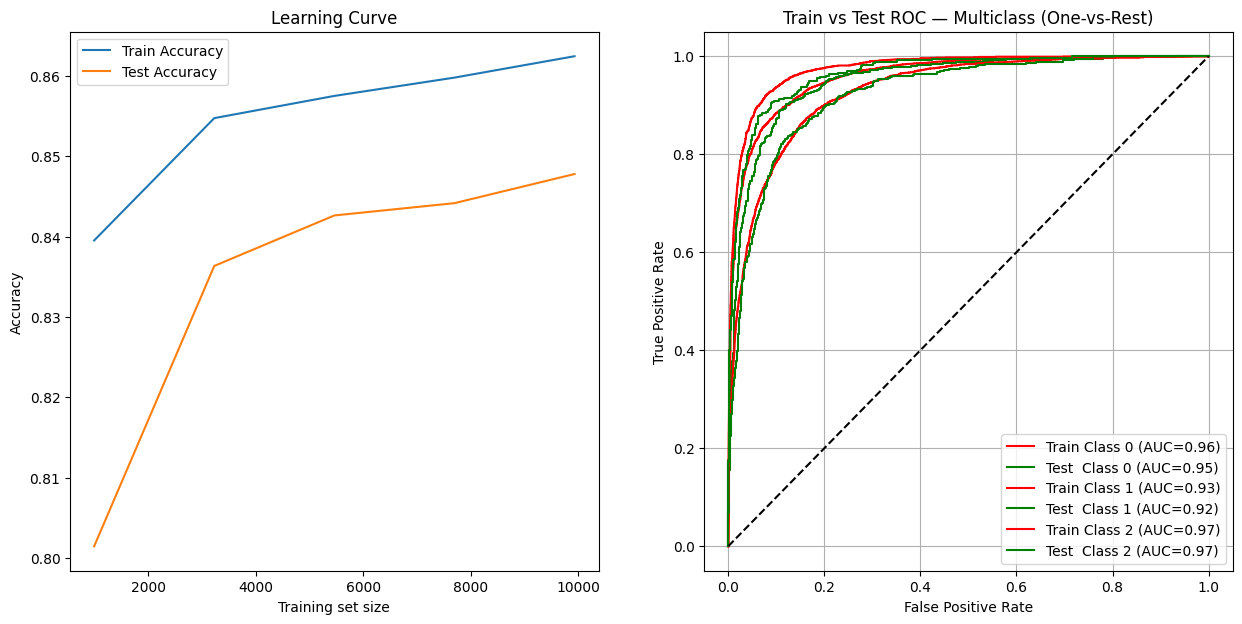

--- Entrainemnt du modèle --------> Random Forest 

Accuracy -->  0.7809219534459151 

Train accuracy: 0.9979049153908138
Test accuracy: 0.7809219534459151
Generalization gap: 0.21698296194489874
Rapport de classification:

              precision    recall  f1-score   support

           0       0.78      0.98      0.87      1374
           1       0.75      0.40      0.52       464
           2       0.85      0.50      0.63       353

    accuracy                           0.78      2191
   macro avg       0.79      0.63      0.67      2191
weighted avg       0.78      0.78      0.76      2191

-----------------------------------------------




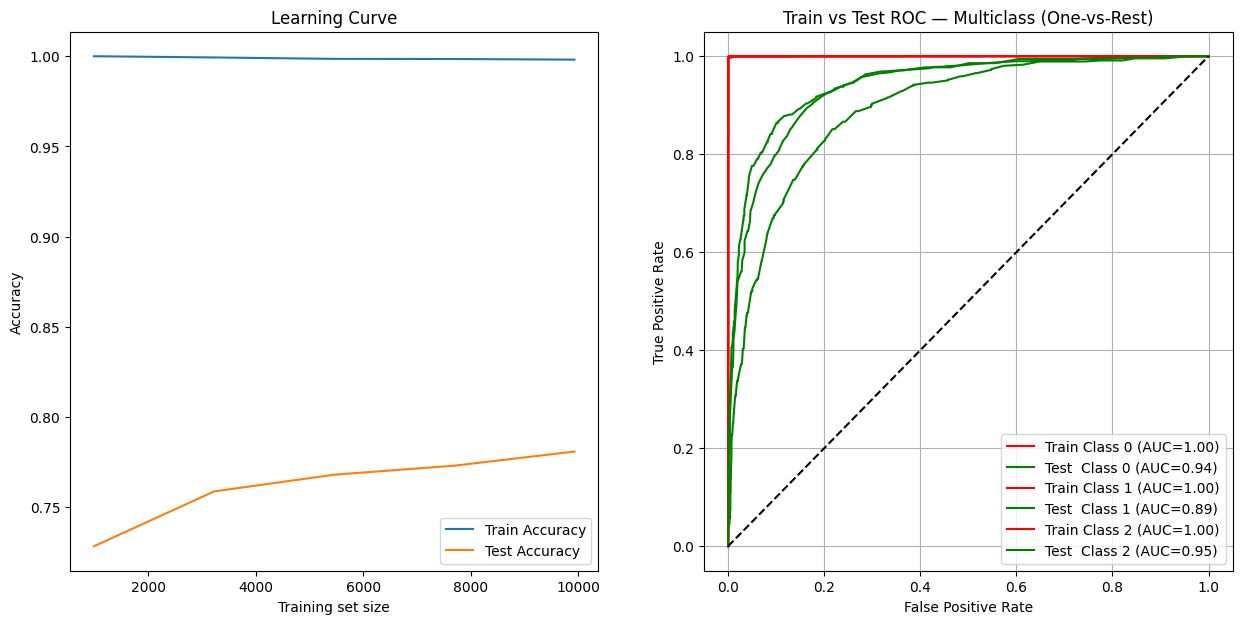

--- Entrainemnt du modèle --------> Linear SVC 

Accuracy -->  0.848927430397079 

Train accuracy: 0.8748589846897663
Test accuracy: 0.848927430397079
Generalization gap: 0.025931554292687342
Rapport de classification:

              precision    recall  f1-score   support

           0       0.90      0.93      0.91      1374
           1       0.73      0.70      0.71       464
           2       0.81      0.75      0.78       353

    accuracy                           0.85      2191
   macro avg       0.81      0.79      0.80      2191
weighted avg       0.85      0.85      0.85      2191

-----------------------------------------------


--- Entrainemnt du modèle --------> XGBoost 

Accuracy -->  0.8402555910543131 

Train accuracy: 0.9979049153908138
Test accuracy: 0.8402555910543131
Generalization gap: 0.1576493243365007
Rapport de classification:

              precision    recall  f1-score   support

           0       0.88      0.94      0.91      1374
           1       0.71

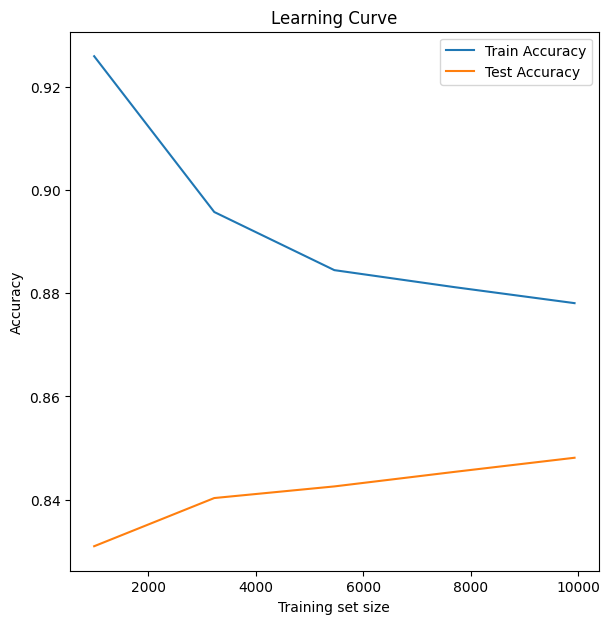

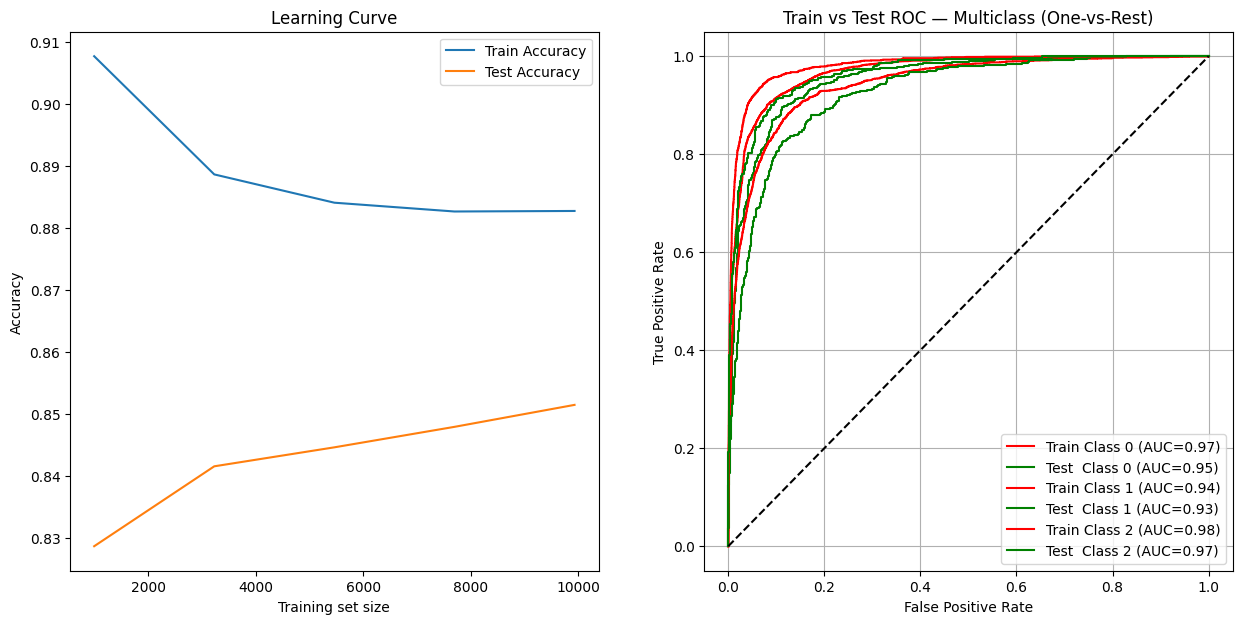

In [73]:
scores_df_clean_1, models_clean_1 = train_multiple_models(*clean_sets)

##### 4.2. Data 2: data_clean (Balanced)

--- Entrainemnt du modèle --------> Logistic Regression 

Accuracy -->  0.8265632131446828 

Train accuracy: 0.8432715551974215
Test accuracy: 0.8265632131446828
Generalization gap: 0.016708342052738634
Rapport de classification:

              precision    recall  f1-score   support

           0       0.95      0.83      0.89      1374
           1       0.63      0.81      0.71       464
           2       0.76      0.81      0.79       353

    accuracy                           0.83      2191
   macro avg       0.78      0.82      0.79      2191
weighted avg       0.85      0.83      0.83      2191

-----------------------------------------------




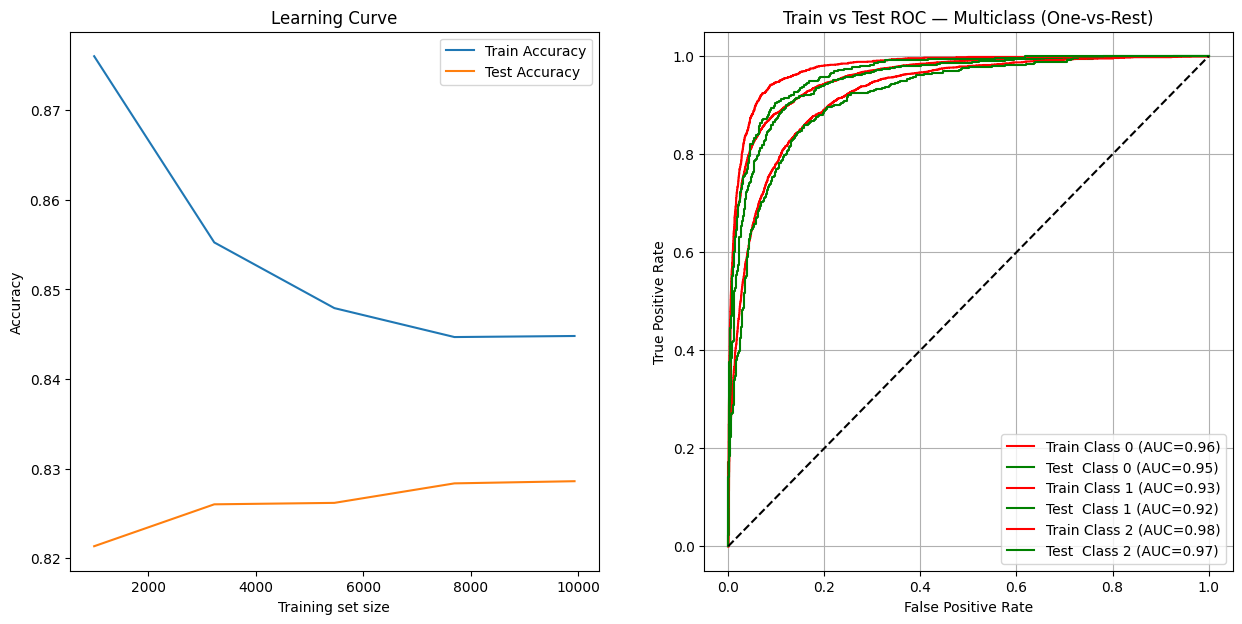

--- Entrainemnt du modèle --------> Random Forest 

Accuracy -->  0.7507987220447284 

Train accuracy: 0.9979049153908138
Test accuracy: 0.7507987220447284
Generalization gap: 0.2471061933460854
Rapport de classification:

              precision    recall  f1-score   support

           0       0.74      0.99      0.84      1374
           1       0.78      0.25      0.38       464
           2       0.86      0.50      0.63       353

    accuracy                           0.75      2191
   macro avg       0.79      0.58      0.62      2191
weighted avg       0.77      0.75      0.71      2191

-----------------------------------------------




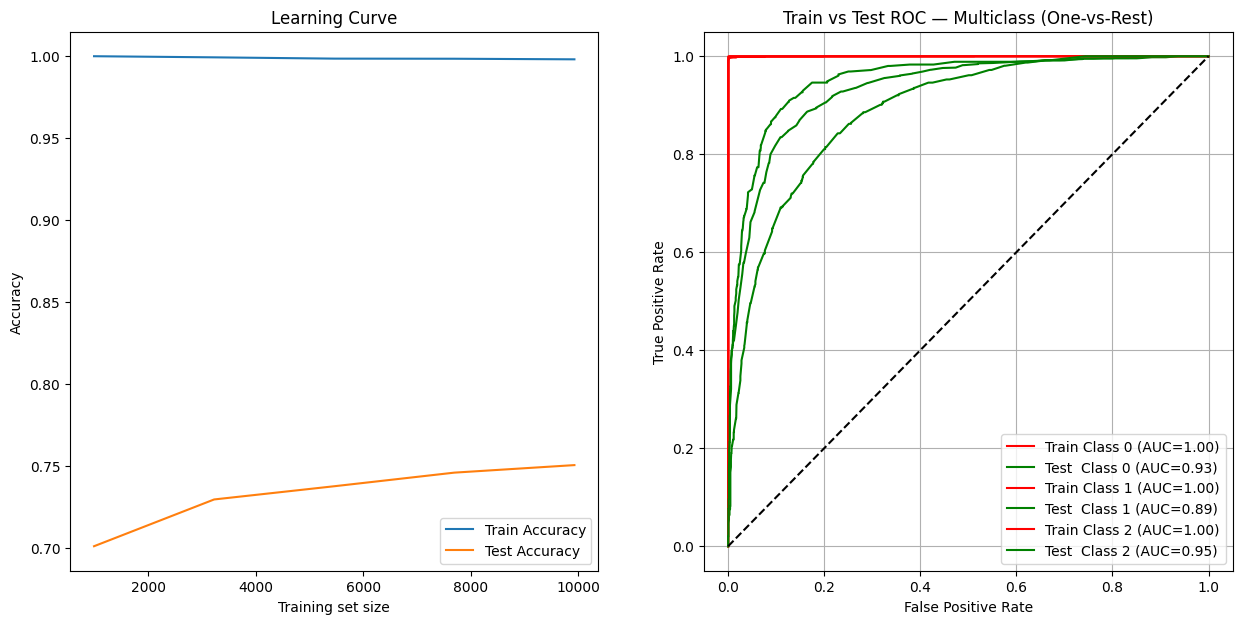

--- Entrainemnt du modèle --------> Linear SVC 

Accuracy -->  0.8457325422181652 

Train accuracy: 0.8712328767123287
Test accuracy: 0.8457325422181652
Generalization gap: 0.025500334494163557
Rapport de classification:

              precision    recall  f1-score   support

           0       0.93      0.88      0.91      1374
           1       0.69      0.78      0.73       464
           2       0.77      0.79      0.78       353

    accuracy                           0.85      2191
   macro avg       0.80      0.82      0.81      2191
weighted avg       0.85      0.85      0.85      2191

-----------------------------------------------


--- Entrainemnt du modèle --------> XGBoost 

Accuracy -->  0.8402555910543131 

Train accuracy: 0.9979049153908138
Test accuracy: 0.8402555910543131
Generalization gap: 0.1576493243365007
Rapport de classification:

              precision    recall  f1-score   support

           0       0.88      0.94      0.91      1374
           1       0.

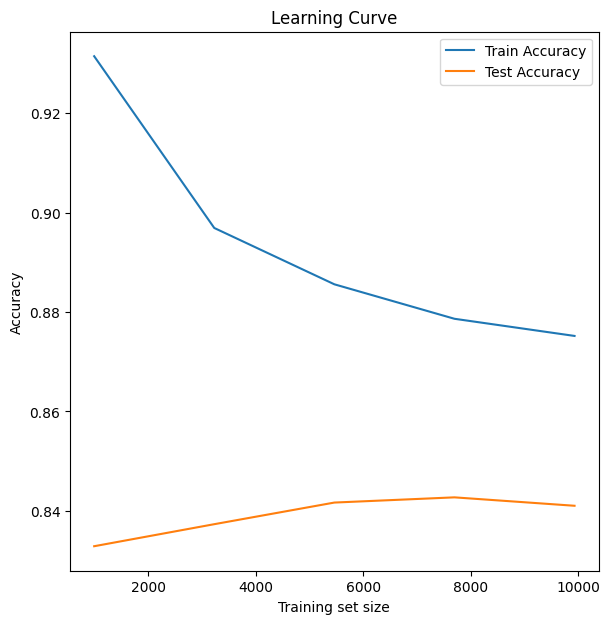

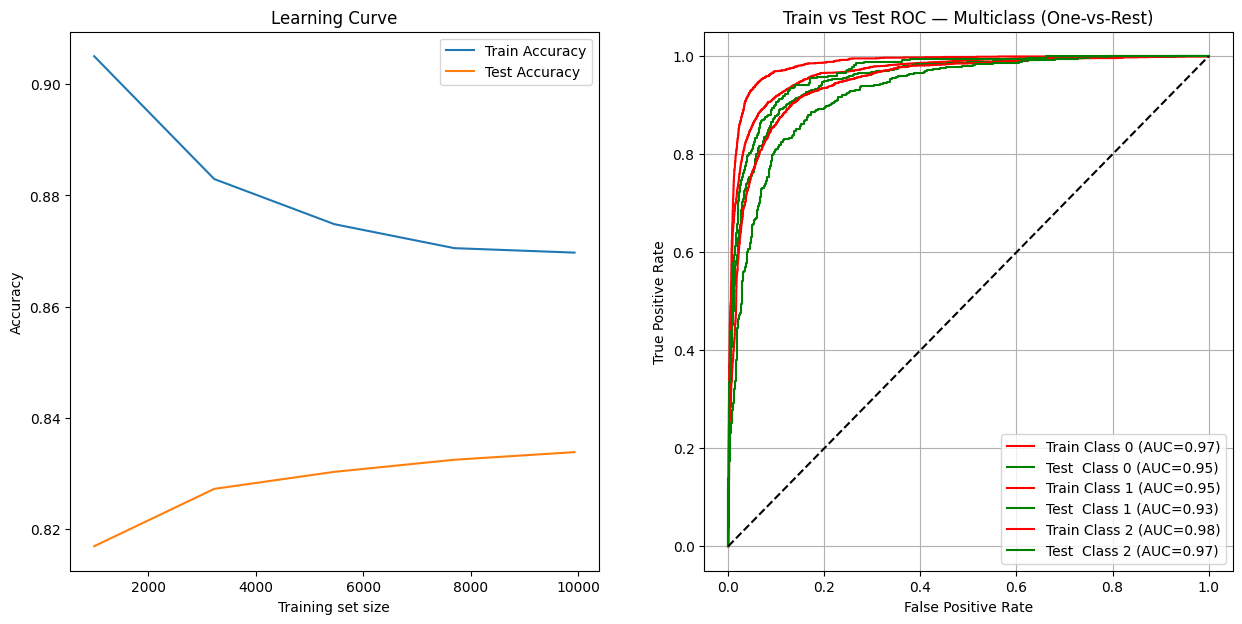

In [74]:
scores_df_clean_2, models_clean_2 = train_multiple_models(*clean_sets, "balanced")

##### 4.3. Data 3: data_with_mentions

--- Entrainemnt du modèle --------> Logistic Regression 

Accuracy -->  0.8233683249657691 

Train accuracy: 0.8431909750201451
Test accuracy: 0.8233683249657691
Generalization gap: 0.019822650054376
Rapport de classification:

              precision    recall  f1-score   support

           0       0.95      0.83      0.89      1374
           1       0.63      0.81      0.71       464
           2       0.73      0.80      0.76       353

    accuracy                           0.82      2191
   macro avg       0.77      0.81      0.79      2191
weighted avg       0.85      0.82      0.83      2191

-----------------------------------------------




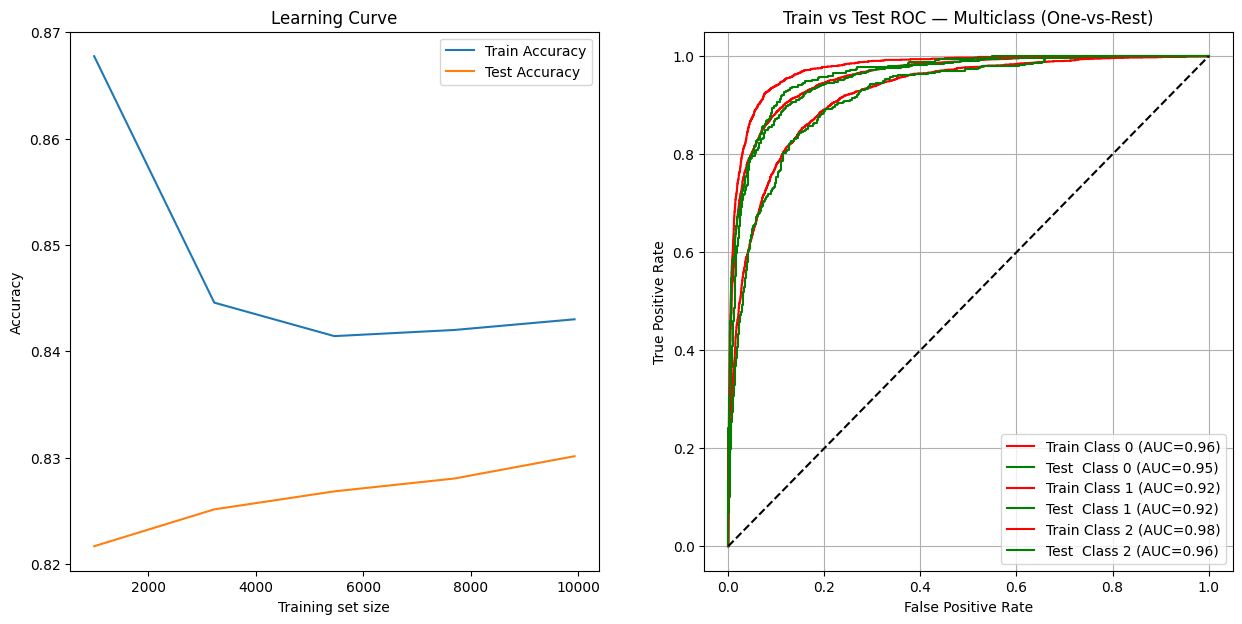

--- Entrainemnt du modèle --------> Random Forest 

Accuracy -->  0.7749885896850753 

Train accuracy: 0.9980660757453667
Test accuracy: 0.7749885896850753
Generalization gap: 0.22307748606029132
Rapport de classification:

              precision    recall  f1-score   support

           0       0.77      0.98      0.86      1374
           1       0.71      0.33      0.45       464
           2       0.87      0.55      0.68       353

    accuracy                           0.77      2191
   macro avg       0.78      0.62      0.66      2191
weighted avg       0.77      0.77      0.75      2191

-----------------------------------------------




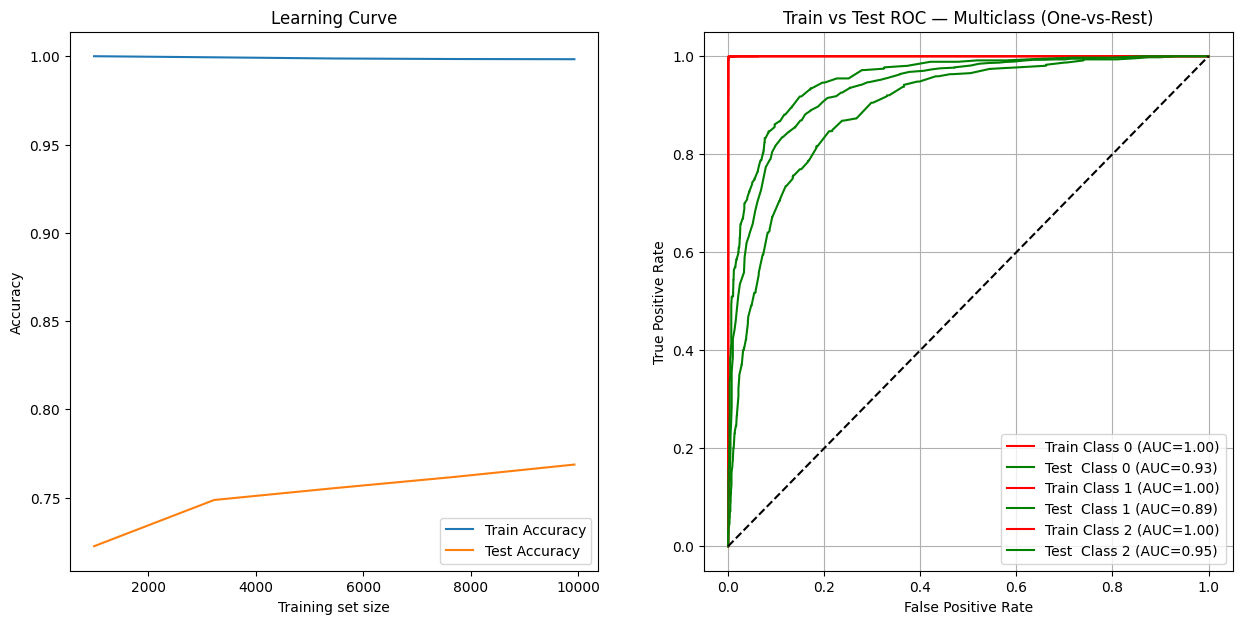

--- Entrainemnt du modèle --------> Linear SVC 

Accuracy -->  0.8407120036513007 

Train accuracy: 0.8705882352941177
Test accuracy: 0.8407120036513007
Generalization gap: 0.02987623164281694
Rapport de classification:

              precision    recall  f1-score   support

           0       0.93      0.89      0.91      1374
           1       0.67      0.76      0.72       464
           2       0.76      0.76      0.76       353

    accuracy                           0.84      2191
   macro avg       0.79      0.80      0.80      2191
weighted avg       0.85      0.84      0.84      2191

-----------------------------------------------


--- Entrainemnt du modèle --------> XGBoost 

Accuracy -->  0.8370607028753994 

Train accuracy: 0.9980660757453667
Test accuracy: 0.8370607028753994
Generalization gap: 0.1610053728699673
Rapport de classification:

              precision    recall  f1-score   support

           0       0.88      0.94      0.91      1374
           1       0.7

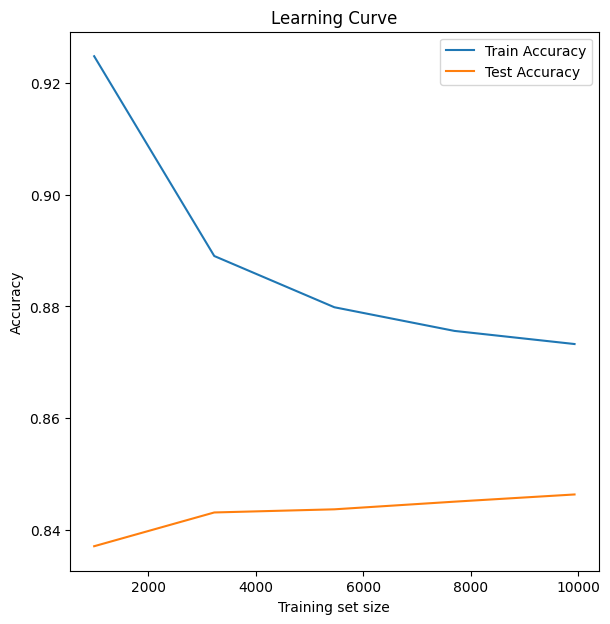

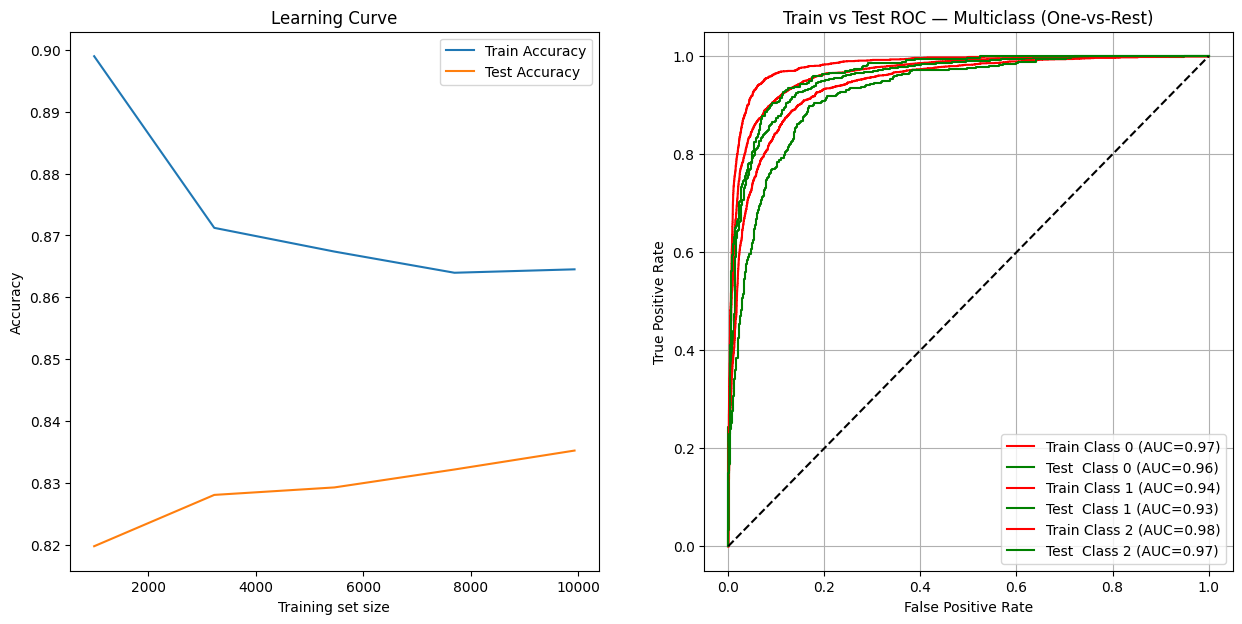

In [75]:
scores_df_mentions, models_mentions = train_multiple_models(*mentions_sets, "balanced")

##### 4.4. Data 4: data_balanced_undersampling

--- Entrainemnt du modèle --------> Logistic Regression 

Accuracy -->  0.8134270101483216 

Train accuracy: 0.830300523848911
Test accuracy: 0.8134270101483216
Generalization gap: 0.016873513700589315
Rapport de classification:

              precision    recall  f1-score   support

           0       0.84      0.86      0.85       464
           1       0.77      0.77      0.77       464
           2       0.83      0.81      0.82       353

    accuracy                           0.81      1281
   macro avg       0.81      0.81      0.81      1281
weighted avg       0.81      0.81      0.81      1281

-----------------------------------------------




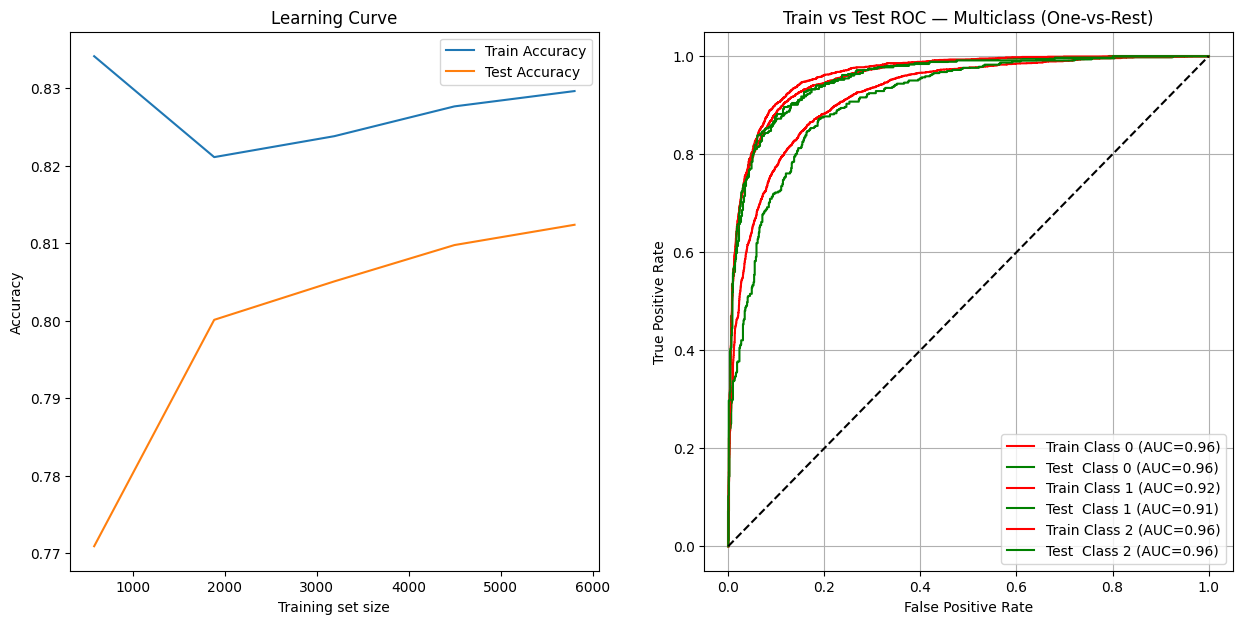

--- Entrainemnt du modèle --------> Random Forest 

Accuracy -->  0.7837626854020296 

Train accuracy: 0.9982078853046595
Test accuracy: 0.7837626854020296
Generalization gap: 0.2144451999026299
Rapport de classification:

              precision    recall  f1-score   support

           0       0.81      0.86      0.84       464
           1       0.72      0.74      0.73       464
           2       0.84      0.73      0.78       353

    accuracy                           0.78      1281
   macro avg       0.79      0.78      0.78      1281
weighted avg       0.79      0.78      0.78      1281

-----------------------------------------------




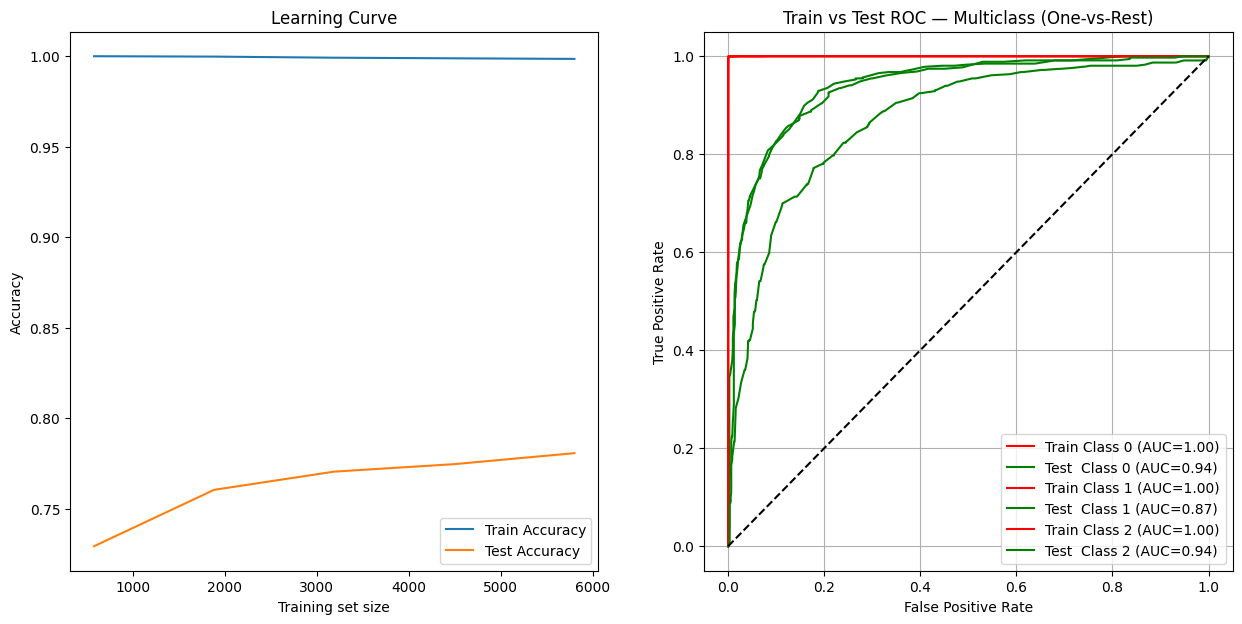

--- Entrainemnt du modèle --------> Linear SVC 

Accuracy -->  0.8095238095238095 

Train accuracy: 0.8508409153570444
Test accuracy: 0.8095238095238095
Generalization gap: 0.04131710583323489
Rapport de classification:

              precision    recall  f1-score   support

           0       0.84      0.85      0.84       464
           1       0.78      0.76      0.77       464
           2       0.81      0.82      0.82       353

    accuracy                           0.81      1281
   macro avg       0.81      0.81      0.81      1281
weighted avg       0.81      0.81      0.81      1281

-----------------------------------------------


--- Entrainemnt du modèle --------> XGBoost 

Accuracy -->  0.790007806401249 

Train accuracy: 0.9982078853046595
Test accuracy: 0.790007806401249
Generalization gap: 0.20820007890341052
Rapport de classification:

              precision    recall  f1-score   support

           0       0.83      0.85      0.84       464
           1       0.75

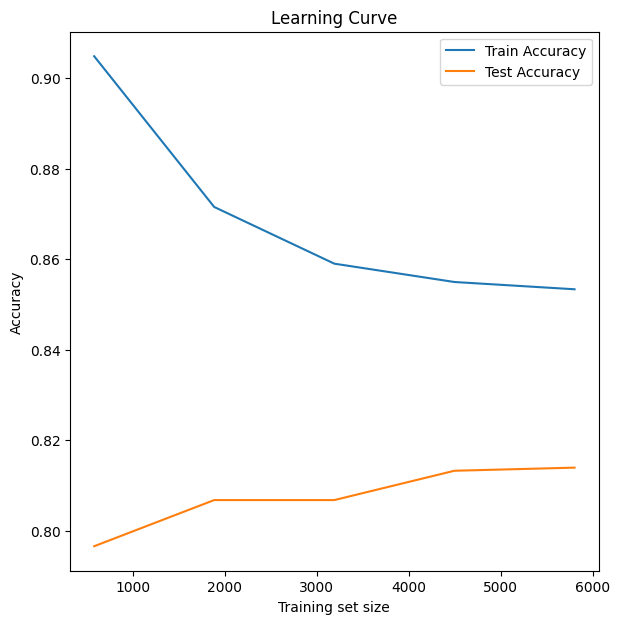

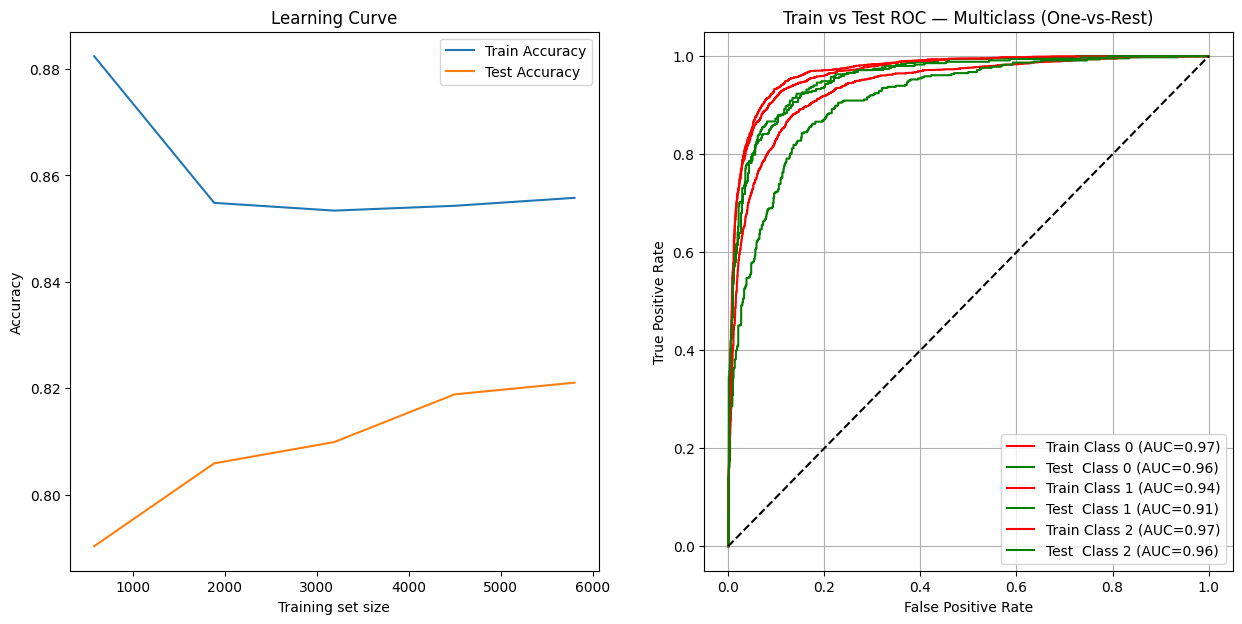

In [76]:
scores_df_undersampling, models_undersampling = train_multiple_models(*undersampling_sets)

##### 5. Comparer les modèles

- Data 1: data_clean

In [77]:
scores_df_clean_1

,Name,Accuracy,Precision,Recall,F1,Train_Test Gap
0,Logistic Regression,0.851209,0.851209,0.851209,0.851209,0.011804
1,Random Forest,0.780922,0.780922,0.780922,0.780922,0.216983
2,Linear SVC,0.848927,0.848927,0.848927,0.848927,0.025932
3,XGBoost,0.840256,0.840256,0.840256,0.840256,0.157649
4,SVC,0.852579,0.852579,0.852579,0.852579,0.028324


- Data 2: data_clean (Balanced)

In [78]:
scores_df_clean_2

,Name,Accuracy,Precision,Recall,F1,Train_Test Gap
0,Logistic Regression,0.826563,0.826563,0.826563,0.826563,0.016708
1,Random Forest,0.750799,0.750799,0.750799,0.750799,0.247106
2,Linear SVC,0.845733,0.845733,0.845733,0.845733,0.025500
3,XGBoost,0.840256,0.840256,0.840256,0.840256,0.157649
4,SVC,0.828389,0.828389,0.828389,0.828389,0.039218


- Data 3: data_with_mentions

In [79]:
scores_df_mentions

,Name,Accuracy,Precision,Recall,F1,Train_Test Gap
0,Logistic Regression,0.823368,0.823368,0.823368,0.823368,0.019823
1,Random Forest,0.774989,0.774989,0.774989,0.774989,0.223077
2,Linear SVC,0.840712,0.840712,0.840712,0.840712,0.029876
3,XGBoost,0.837061,0.837061,0.837061,0.837061,0.161005
4,SVC,0.825194,0.825194,0.825194,0.825194,0.038464


- Data 4: data_balanced_undersampling

In [80]:
scores_df_undersampling

,Name,Accuracy,Precision,Recall,F1,Train_Test Gap
0,Logistic Regression,0.813427,0.813427,0.813427,0.813427,0.016874
1,Random Forest,0.783763,0.783763,0.783763,0.783763,0.214445
2,Linear SVC,0.809524,0.809524,0.809524,0.809524,0.041317
3,XGBoost,0.790008,0.790008,0.790008,0.790008,0.208200
4,SVC,0.815769,0.815769,0.815769,0.815769,0.037416


Random Forest et XGBoost présentent des signes d’overfitting ; ils sont donc écartés. Parmi les modèles restants, la régression logistique offre le meilleur équilibre entre une accuracy élevée, un F1-score acceptable et un écart très faible entre l’accuracy d’entraînement et celle de test (train_acc ≈ test_acc), indiquant l’absence de surapprentissage.

Parmi les modèles de régression logistique entraînés, on peut choisir le premier modèle entraîné sur le jeu de données Data 1.

##### 6. Sauvegarder le meilleur modèle pour la prédiction

In [ ]:
import joblib as jb

jb.dump(models_clean_1['Logistic Regression'], '../models/ml/logistic_regression_1.pkl')

print("Le modèle a été enregistré !")

Le modèle a été enregistré !


##### 7. Optimiser le modèle

- Appliquer grid search

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

log_reg = LogisticRegression(random_state=42)

param_grid = {
    'C': [2, 3, 4, 5],
    'solver': ['lbfgs', 'saga'],
    'max_iter': [50, 100, 200]
}

grid_search = GridSearchCV(
    estimator=log_reg,
    param_grid=param_grid,
    scoring='f1_macro',
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(clean_sets[0], clean_sets[1])

print("Best parameters:", grid_search.best_params_)
print("Best CV score:", grid_search.best_score_)

best_model = grid_search.best_estimator_

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best parameters: {'C': 3, 'max_iter': 50, 'solver': 'saga'}
Best CV score: 0.8004116552256525


- Re-entrainer le modéle avec les mielleurs paramètres

In [111]:
log_reg = LogisticRegression(
    random_state=42,
    C=3,
    solver="saga",
    max_iter=50
)

log_reg.fit(clean_sets[0], clean_sets[1])

train_pred = log_reg.predict(clean_sets[0])
test_pred = log_reg.predict(clean_sets[2])

train_acc = accuracy_score(clean_sets[1], train_pred)
test_acc = accuracy_score(clean_sets[3], test_pred)

print(train_acc)
print(test_acc)
print(train_acc - test_acc)

0.8709105560032232
0.851665905979005
0.019244650024218157


- Sauvegarder le modèle

In [ ]:
import joblib as jb

jb.dump(log_reg, '../models/ml/logistic_regression_cv.pkl')

print("Le modèle a été enregistré !")

Le modèle a été enregistré !
